## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 06. Categorical DQN

[M. G. Bellemare et al., "A Distributional Perspective on Reinforcement Learning." arXiv preprint arXiv:1707.06887, 2017.](https://arxiv.org/pdf/1707.06887.pdf)

The authors argued the importance of learning the distribution of returns instead of the expected return, and they proposed to model such distributions with probability masses placed on a discrete support $z$, where $z$ is a vector with $N_{atoms} \in \mathbb{N}^+$ atoms, defined by $z_i = V_{min} + (i-1) \frac{V_{max} - V_{min}}{N-1}$ for $i \in \{1, ..., N_{atoms}\}$.

The key insight is that return distributions satisfy a variant of Bellman’s equation. For a given state $S_t$ and action $A_t$, the distribution of the returns under the optimal policy $\pi^{*}$ should match a target distribution defined by taking the distribution for the next state $S_{t+1}$ and action $a^{*}_{t+1} = \pi^{*}(S_{t+1})$, contracting
it towards zero according to the discount, and shifting it by the reward (or distribution of rewards, in the stochastic case). A distributional variant of Q-learning is then derived by first constructing a new support for the target distribution, and then minimizing the Kullbeck-Leibler divergence between the distribution $d_t$ and the target distribution

$$
d_t' = (R_{t+1} + \gamma_{t+1} z, p_\hat{{\theta}} (S_{t+1}, \hat{a}^{*}_{t+1})),\\
D_{KL} (\phi_z d_t' \| d_t).
$$

Here $\phi_z$ is a L2-projection of the target distribution onto the fixed support $z$, and $\hat{a}^*_{t+1} = \arg\max_{a} q_{\hat{\theta}} (S_{t+1}, a)$ is the greedy action with respect to the mean action values $q_{\hat{\theta}} (S_{t+1}, a) = z^{T}p_{\theta}(S_{t+1}, a)$ in state $S_{t+1}$.

In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

/Users/jinwoo.park/miniforge3/envs/rainbow-is-all-you-need/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Replay buffer

Please see *01.dqn.ipynb* for detailed description.

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

The parametrized distribution can be represented by a neural network, as in DQN, but with atom_size x out_dim outputs. A softmax is applied independently for each action dimension of the output to ensure that the distribution for each action is appropriately normalized.

To estimate q-values, we use inner product of each action's softmax distribution and support which is the set of atoms $\{z_i = V_{min} + i\Delta z: 0 \le i < N\}, \Delta z = \frac{V_{max} - V_{min}}{N-1}$.

$$
Q(s_t, a_t) = \sum_i z_i p_i(s_t, a_t), \\
\text{where } p_i \text{ is the probability of } z_i \text{ (the output of softmax)}.
$$

In [4]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size
        
        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim * atom_size)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        q_atoms = self.layers(x).view(-1, self.out_dim, self.atom_size)
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist

## Categorical DQN Agent


Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

All differences from pure DQN are noted with comments *Categorical DQN*.

In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device),
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state, _ = self.env.reset(seed=self.seed)
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env


    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            next_action = self.dqn_target(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * self.gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.floor().long() + 1

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u.clamp(max=self.atom_size - 1) + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])

        loss = -(proj_dist * log_p).sum(1).mean()

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [6]:
# environment
env = gym.make("CartPole-v1", max_episode_steps=200, render_mode="rgb_array")

## Set random seed

In [7]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initialize

In [8]:
# parameters
num_frames = 10000
memory_size = 2000
batch_size = 32
target_update = 150
epsilon_decay = 1 / 2000

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cpu


## Train

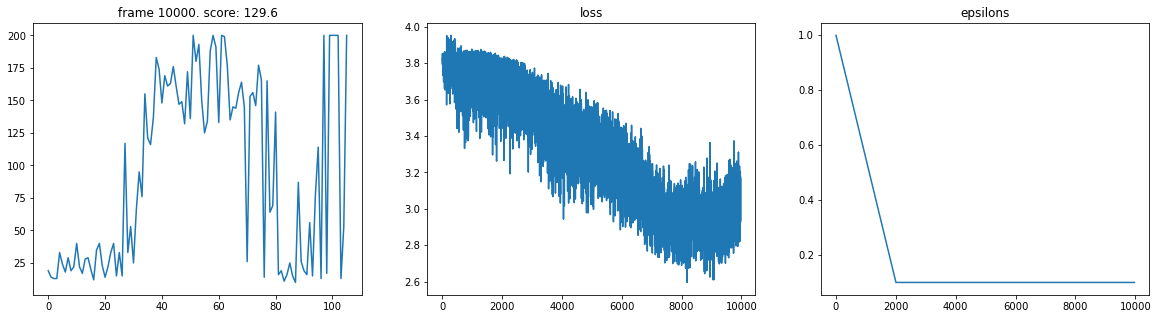

In [9]:
agent.train(num_frames)

## Test

Run the trained agent (1 episode).

In [10]:
video_folder="videos/categorical_dqn"
agent.test(video_folder=video_folder)

Moviepy - Building video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/categorical_dqn/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/categorical_dqn/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jinwoo.park/Repositories/rainbow-is-all-you-need/videos/categorical_dqn/rl-video-episode-0.mp4
score:  200.0


## Render

In [11]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/categorical_dqn/rl-video-episode-0.mp4
